### End-to-End Wireless Communication System Simulation

In [61]:
import numpy as np
import matplotlib.pyplot as plt

In [83]:
MESSAGE = "This is test message."
TYPE = "text"
if TYPE == "text":
    ascii_msg = [ord(c) for c in MESSAGE]
    binary_msg = []
    for asc in ascii_msg:
        binary_str = format(asc,'08b')
        binary_msg.append([int(b) for b in binary_str])

print(binary_msg)
message_bits = np.array([b for block in binary_msg for b in block])
print("\nOriginal message bits sequence\n")
print(message_bits)

[[0, 1, 0, 1, 0, 1, 0, 0], [0, 1, 1, 0, 1, 0, 0, 0], [0, 1, 1, 0, 1, 0, 0, 1], [0, 1, 1, 1, 0, 0, 1, 1], [0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 1, 0, 1, 0, 0, 1], [0, 1, 1, 1, 0, 0, 1, 1], [0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 1, 1, 0, 1, 0, 0], [0, 1, 1, 0, 0, 1, 0, 1], [0, 1, 1, 1, 0, 0, 1, 1], [0, 1, 1, 1, 0, 1, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 1, 0, 1, 1, 0, 1], [0, 1, 1, 0, 0, 1, 0, 1], [0, 1, 1, 1, 0, 0, 1, 1], [0, 1, 1, 1, 0, 0, 1, 1], [0, 1, 1, 0, 0, 0, 0, 1], [0, 1, 1, 0, 0, 1, 1, 1], [0, 1, 1, 0, 0, 1, 0, 1], [0, 0, 1, 0, 1, 1, 1, 0]]

Original message bits sequence

[0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0
 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1
 1 0 0 1 0 1 0 1 1 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0
 1 0 1 1 0 0 1 0 1 0 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 0 1 1 0 0 0 0 1 0 1 1 0
 0 1 1 1 0 1 1 0 0 1 0 1 0 0 1 0 1 1 1 0]


In [84]:
#QPSK Modulation
def qspk_modulation(message_bits):
    pairs = message_bits.reshape(-1,2)

    qpsk_mapping = {
        (0,0): 1+1j,
        (1,0): -1+1j,
        (1,1): -1-1j,
        (0,1): 1-1j
    }

    symbols = np.array([qpsk_mapping[tuple(b)] for b in pairs])
    symbols /= np.sqrt(2)
    return symbols

In [ ]:
# Wireless channel modelling
def add_awgn(symbols, snr_db):
    snr_linear = pow(10,snr_db/10)
    noise_variance = 1/snr_linear
    noise_sd = np.sqrt(noise_variance/2)

    noise = np.random.normal(0,noise_sd,symbols.shape) + 1j * np.random.normal(0,noise_sd,symbols.shape)

    return symbols+noise

def add_rayleigh_fading(symbols, snr_db):
    pass

In [65]:
#QPSK demodulation
def qpsk_demodulation(modulated_symbols):
    message = np.array([])

    for s in modulated_symbols:
        b1 = 0 if s.real >=0 else 1
        b2 = 0 if s.imag >=0 else 1
        message = np.append(message,[b1,b2])
    return message

In [81]:
def calc_BER(tx,rx):
    mismatches = np.sum(tx != rx)

    ber = mismatches / len(tx)

    return ber, mismatches


Modulated Message bits sequence:

[ 0.70710678-0.70710678j  0.70710678-0.70710678j  0.70710678-0.70710678j
  0.70710678+0.70710678j  0.70710678-0.70710678j -0.70710678+0.70710678j
 -0.70710678+0.70710678j  0.70710678+0.70710678j  0.70710678-0.70710678j
 -0.70710678+0.70710678j -0.70710678+0.70710678j  0.70710678-0.70710678j
  0.70710678-0.70710678j -0.70710678-0.70710678j  0.70710678+0.70710678j
 -0.70710678-0.70710678j  0.70710678+0.70710678j -0.70710678+0.70710678j
  0.70710678+0.70710678j  0.70710678+0.70710678j  0.70710678-0.70710678j
 -0.70710678+0.70710678j -0.70710678+0.70710678j  0.70710678-0.70710678j
  0.70710678-0.70710678j -0.70710678-0.70710678j  0.70710678+0.70710678j
 -0.70710678-0.70710678j  0.70710678+0.70710678j -0.70710678+0.70710678j
  0.70710678+0.70710678j  0.70710678+0.70710678j  0.70710678-0.70710678j
 -0.70710678-0.70710678j  0.70710678-0.70710678j  0.70710678+0.70710678j
  0.70710678-0.70710678j -0.70710678+0.70710678j  0.70710678-0.70710678j
  0.70710678-0.7

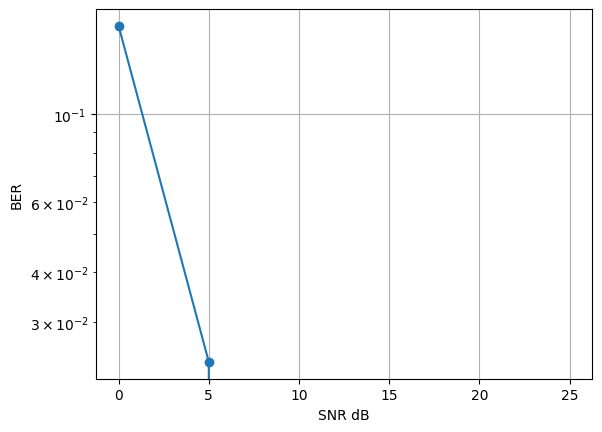

In [82]:
# Overall Pipeine

#Modulation
symbols = qspk_modulation(message_bits=message_bits)
print("\nModulated Message bits sequence:\n")
print(symbols)

snr = range(0,30,5)
demod_bits = []
ber_values = []

for s in snr:
    rx_bits = add_awgn(symbols=symbols, snr_db=s) #noise at different snr level

    demod_bits = qpsk_demodulation(rx_bits)
    print(f"\nDemodulated Message bits sequence (SNR = {s} dB):\n")
    print(demod_bits)

    ber_value, mismatch_counts = calc_BER(message_bits, demod_bits)
    ber_values.append(ber_value)
    print(f"For SNR = {s} dB,  Mismatches: {mismatch_counts}, BER = {ber_value}")
    

plt.semilogy(list(snr), ber_values, marker='o')
plt.xlabel('SNR dB')
plt.ylabel('BER')
plt.grid(True)
plt.show()